# Develop adjoint LBVP - example

## Option 1: Avoid convert

In [1]:
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import numpy as np

from scipy import optimize

logger = logging.getLogger(__name__)


# Parameters
Ny = 128
dtype = np.complex128

# Bases
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ChebyshevT(coords['y'], size=Ny,dealias=1, bounds=(0, 2))

transform = ybasis.transform_plan(Ny)

y, = dist.local_grids(ybasis)

dy = lambda A: d3.Differentiate(A, coords['y'])

# Fields
u = dist.Field(name='u', bases=(ybasis))
v = dist.Field(name='v', bases=(ybasis))
w = dist.Field(name='w', bases=(ybasis))

gradu = dist.Field(name='gradu', bases=(ybasis))
gradv = dist.Field(name='gradv', bases=(ybasis))
gradw = dist.Field(name='gradw', bases=(ybasis))

U = dist.Field(name='U',bases=(ybasis))
U['g'] = y*(2-y)
Uy = dy(U)
alpha = -1
beta = 0
p = dist.Field(name='p', bases=(ybasis))
tau_u_1 = dist.Field(name='tau_u_1')
tau_u_2 = dist.Field(name='tau_u_2')

tau_v_1 = dist.Field(name='tau_v_1')
tau_v_2 = dist.Field(name='tau_v_2')

tau_w_1 = dist.Field(name='tau_w_1')
tau_w_2 = dist.Field(name='tau_w_2')

tau_p = dist.Field(name='tau_p')

ybasis2 = ybasis.derivative_basis(2)
transform2 = ybasis2.transform_plan(Ny)
# # Forcing
fu = dist.Field(name='fu',bases=(ybasis2))
fv = dist.Field(name='fv',bases=(ybasis2))
fw = dist.Field(name='fw',bases=(ybasis2))

# # Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
Re = 1000
omega = dist.Field(name='omega')
omega['g'] = 0.278
# # Problem
problem = d3.LBVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem.add_equation("1j*omega*u + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = fu")
problem.add_equation("1j*omega*v + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = fv")
problem.add_equation("1j*omega*w + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = fw")
problem.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem.add_equation("u(y=0) = 0")
problem.add_equation("u(y=2) = 0")

problem.add_equation("v(y=0) = 0")
problem.add_equation("v(y=2) = 0")

problem.add_equation("w(y=0) = 0")
problem.add_equation("w(y=2) = 0")

In [2]:
# Solver
solver = problem.build_solver()
# Check fu has the right bases to avoid convert
print(fu.domain.bases[0])
print(solver.F[0].domain.bases[0])

Jacobi(y, 128, a0=-0.5, b0=-0.5, a=1.5, b=1.5, dealias=1)
Jacobi(y, 128, a0=-0.5, b0=-0.5, a=1.5, b=1.5, dealias=1)


In [3]:
# Simple weight matrix using the Trapezium rule
# TODO: spectrally accurate weight matrix
def weightMatrixDisc():
    W = np.zeros(Ny)
    for i in range(Ny):
        if(i==0):
            W[i] = 0.5*(y[1]-y[0])
        elif(i==Ny-1):
            W[i] = 0.5*(y[Ny-1]-y[Ny-2])
        else:
            W[i] = 0.5*(y[i]-y[i-1]) + 0.5*(y[i+1]-y[i])
    return W
W = weightMatrixDisc()

In [4]:
def directAdjointLoopGrid(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    
    fu['g'] = forcing[:Ny]+1j*forcing[Ny:2*Ny]
    fv['g'] = forcing[2*Ny:3*Ny]+1j*forcing[3*Ny:4*Ny]
    fw['g'] = forcing[4*Ny:5*Ny]+1j*forcing[5*Ny:6*Ny]
    
    forcNorm = np.sum(np.conj(fu['g'].copy())*W*fu['g'].copy()).real
    forcNorm += np.sum(np.conj(fv['g'].copy())*W*fv['g'].copy()).real
    forcNorm += np.sum(np.conj(fw['g'].copy())*W*fw['g'].copy()).real
    fu['c']
    fv['c']
    fw['c']
    solver.solve()

    cost = np.sum(np.conj(solver.state[0]['g'])*W*solver.state[0]['g']).real
    cost += np.sum(np.conj(solver.state[1]['g'])*W*solver.state[1]['g']).real
    cost += np.sum(np.conj(solver.state[2]['g'])*W*solver.state[2]['g']).real

    cost = cost/forcNorm
    
    tmp0 = np.zeros(Ny,dtype=dtype) 
    tmp1 = np.zeros(Ny,dtype=dtype)
    tmp2 = np.zeros(Ny,dtype=dtype)
    
    v0 = W*u['g']/forcNorm
    v1 = W*v['g']/forcNorm
    v2 = W*w['g']/forcNorm
    
    transform.backward_adjoint(v0,tmp0,0)
    transform.backward_adjoint(v1,tmp1,0)
    transform.backward_adjoint(v2,tmp2,0)
        
    solver.state_adj[0]['c'] = tmp0
    solver.state_adj[1]['c'] = tmp1
    solver.state_adj[2]['c'] = tmp2
    
    solver.solve_adjoint()
    
    tmp0 = np.zeros(Ny,dtype=dtype) 
    tmp1 = np.zeros(Ny,dtype=dtype)
    tmp2 = np.zeros(Ny,dtype=dtype)
    
    v0 = solver.F_adj[0]['c'].copy()
    v1 = solver.F_adj[1]['c'].copy()
    v2 = solver.F_adj[2]['c'].copy()

    transform2.forward_adjoint(v0,tmp0,0)
    transform2.forward_adjoint(v1,tmp1,0)
    transform2.forward_adjoint(v2,tmp2,0)
    
    gradu['g'] = -cost/forcNorm*W*fu['g']  + tmp0
    gradv['g'] = -cost/forcNorm*W*fv['g']  + tmp1
    gradw['g'] = -cost/forcNorm*W*fw['g']  + tmp2

    graduDat = np.hstack((gradu['g'].real,gradu['g'].imag))
    gradvDat = np.hstack((gradv['g'].real,gradv['g'].imag))
    gradwDat = np.hstack((gradw['g'].real,gradw['g'].imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -grad

In [5]:
opts = {'disp': True}
forcing = np.random.rand(Ny*2*3)

sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True,options=opts)

2023-03-06 17:07:06,741 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s
2023-03-06 17:07:06,792 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          768     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74596D+01    |proj g|=  1.06199D+00

At iterate    1    f= -7.80641D+02    |proj g|=  1.04447D+00

At iterate    2    f= -8.59830D+02    |proj g|=  2.38683D-01

At iterate    3    f= -8.92513D+02    |proj g|=  1.37320D-01

At iterate    4    f= -9.06254D+02    |proj g|=  3.92856D-02

At iterate    5    f= -9.07225D+02    |proj g|=  2.54616D-02

At iterate    6    f= -9.07532D+02    |proj g|=  1.50017D-02

At iterate    7    f= -9.07626D+02    |proj g|=  7.03238D-03

At iterate    8    f= -9.07652D+02    |proj g|=  3.70917D-03

At iterate

 This problem is unconstrained.


Text(0.5, 1.0, 'Optimal response')

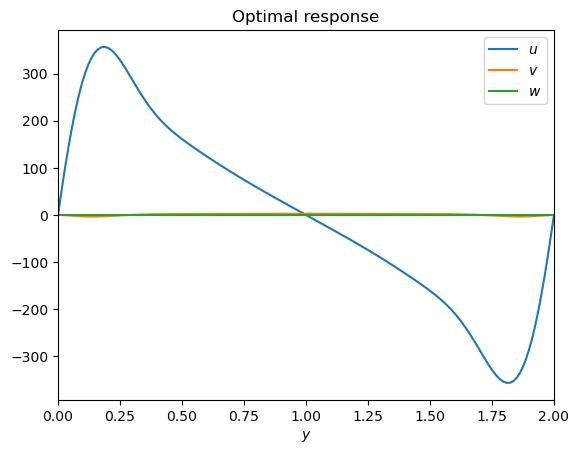

In [6]:
plt.plot(y,u['g'].real,label=r'$u$')
plt.plot(y,v['g'].real,label=r'$v$')
plt.plot(y,w['g'].real,label=r'$w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title('Optimal response')

Text(0.5, 1.0, 'Optimal forcing')

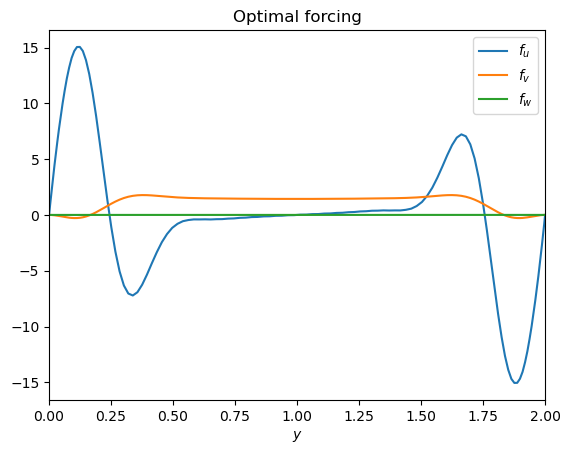

In [7]:
plt.plot(y,fu['g'].real,label=r'$f_u$')
plt.plot(y,fv['g'].real,label=r'$f_v$')
plt.plot(y,fw['g'].real,label=r'$f_w$')
plt.legend()
plt.xlabel(r'$y$')
plt.xlim([0,2])
plt.title('Optimal forcing')

In [8]:
%%time
omegas = np.linspace(0.1,1.5,120)
gains = []
for omega_v in omegas:
    omega['g'] = omega_v
    solver = problem.build_solver()
    sol = optimize.minimize(directAdjointLoopGrid,forcing,method='L-BFGS-B',jac=True)
    gains.append(sol.fun)
gains = -np.array(gains)

2023-03-06 17:07:07,698 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2023-03-06 17:07:07,748 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2023-03-06 17:07:07,890 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-06 17:07:07,935 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-03-06 17:07:08,069 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-06 17:07:08,113 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-06 17:07:08,244 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-06 17:07:08,289 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-06 17:07:13,478 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:13,620 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-06 17:07:13,663 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:13,791 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:13,834 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:13,969 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-06 17:07:14,013 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:14,191 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-06 17:07:19,159 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:19,202 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:19,331 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:19,374 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-06 17:07:19,505 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:19,549 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-06 17:07:19,685 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:19,728 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-06 17:07:24,528 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:24,645 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:24,688 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:24,804 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:24,848 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-06 17:07:24,959 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:25,001 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:25,113 subsystems 0/1 INFO :: Building subproblem matrices 

(0.1, 1.5)

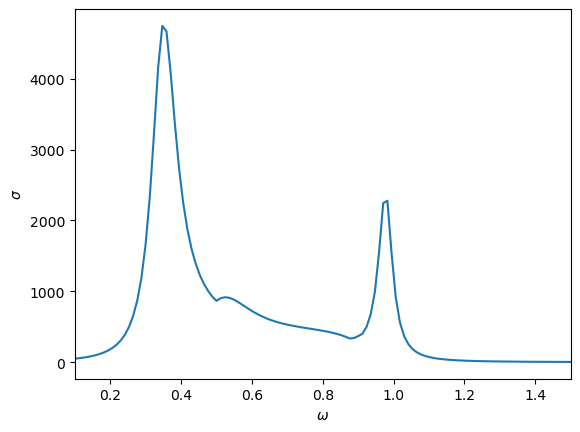

In [9]:
plt.plot(omegas,gains)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma$')
plt.xlim([omegas[0],omegas[-1]])

## Option 2: with adjoint convert

In [10]:
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
import numpy as np
from dedalus.core import operators

from scipy import optimize

logger = logging.getLogger(__name__)


# Parameters
Ny = 128
dtype = np.complex128

# Bases
coords = d3.CartesianCoordinates('y')
dist = d3.Distributor(coords, dtype=dtype)
ybasis = d3.ChebyshevT(coords['y'], size=Ny,dealias=1, bounds=(0, 2))

transform = ybasis.transform_plan(Ny)

y, = dist.local_grids(ybasis)

dy = lambda A: d3.Differentiate(A, coords['y'])

# Fields
u = dist.Field(name='u', bases=(ybasis))
v = dist.Field(name='v', bases=(ybasis))
w = dist.Field(name='w', bases=(ybasis))

gradu = dist.Field(name='gradu', bases=(ybasis))
gradv = dist.Field(name='gradv', bases=(ybasis))
gradw = dist.Field(name='gradw', bases=(ybasis))

U = dist.Field(name='U',bases=(ybasis))
U['g'] = y*(2-y)
Uy = dy(U)
alpha = -1
beta = 0
p = dist.Field(name='p', bases=(ybasis))
tau_u_1 = dist.Field(name='tau_u_1')
tau_u_2 = dist.Field(name='tau_u_2')

tau_v_1 = dist.Field(name='tau_v_1')
tau_v_2 = dist.Field(name='tau_v_2')

tau_w_1 = dist.Field(name='tau_w_1')
tau_w_2 = dist.Field(name='tau_w_2')

tau_p = dist.Field(name='tau_p')

ybasis2 = ybasis.derivative_basis(2)
transform2 = ybasis2.transform_plan(Ny)
# # Forcing
fu = dist.Field(name='fu',bases=(ybasis))
fv = dist.Field(name='fv',bases=(ybasis))
fw = dist.Field(name='fw',bases=(ybasis))

# # Substitutions
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
Re = 1000
omega = dist.Field(name='omega')
omega['g'] = 0.278
# # Problem
problem = d3.LBVP([u,v,w,p, tau_u_1, tau_u_2,tau_v_1, tau_v_2,tau_w_1, tau_w_2], namespace=locals())
problem.add_equation("1j*omega*u + 1j*alpha*u*U + v*Uy - 1/Re*(dy(dy(u))-alpha**2*u-beta**2*u) + lift(tau_u_1,-1) + lift(tau_u_2,-2) + 1j*alpha*p = fu")
problem.add_equation("1j*omega*v + 1j*alpha*v*U - 1/Re*(dy(dy(v))-alpha**2*v-beta**2*v) + lift(tau_v_1,-1) + lift(tau_v_2,-2) + dy(p) = fv")
problem.add_equation("1j*omega*w + 1j*alpha*w*U - 1/Re*(dy(dy(w))-alpha**2*w-beta**2*w) + lift(tau_w_1,-1) + lift(tau_w_2,-2) + 1j*beta*p = fw")
problem.add_equation("1j*alpha*u + dy(v) + 1j*beta*w = 0")

problem.add_equation("u(y=0) = 0")
problem.add_equation("u(y=2) = 0")

problem.add_equation("v(y=0) = 0")
problem.add_equation("v(y=2) = 0")

problem.add_equation("w(y=0) = 0")
problem.add_equation("w(y=2) = 0")

In [11]:
# Solver
solver = problem.build_solver()
# Check fu has the different bases so adjoint connvert needed
print(fu.domain.bases[0])
print(solver.F[0].domain.bases[0])

Jacobi(y, 128, a0=-0.5, b0=-0.5, a=-0.5, b=-0.5, dealias=1)
Jacobi(y, 128, a0=-0.5, b0=-0.5, a=1.5, b=1.5, dealias=1)


In [12]:
def directAdjointLoopGridConvert(forcing):
    '''
    Take a forcing vector and return the cost and gradient. In grid space
    '''
    # Takes a field f forward via the Resolvent (LBVP)
    # Setup Direct problem

    
    fu['g'] = forcing[:Ny]+1j*forcing[Ny:2*Ny]
    fv['g'] = forcing[2*Ny:3*Ny]+1j*forcing[3*Ny:4*Ny]
    fw['g'] = forcing[4*Ny:5*Ny]+1j*forcing[5*Ny:6*Ny]
    
    forcNorm = np.sum(np.conj(fu['g'].copy())*W*fu['g'].copy()).real
    forcNorm += np.sum(np.conj(fv['g'].copy())*W*fv['g'].copy()).real
    forcNorm += np.sum(np.conj(fw['g'].copy())*W*fw['g'].copy()).real
    fu['c']
    fv['c']
    fw['c']
    solver.solve()

    cost = np.sum(np.conj(solver.state[0]['g'])*W*solver.state[0]['g']).real
    cost += np.sum(np.conj(solver.state[1]['g'])*W*solver.state[1]['g']).real
    cost += np.sum(np.conj(solver.state[2]['g'])*W*solver.state[2]['g']).real

    cost = cost/forcNorm
    
    tmp0 = np.zeros(Ny,dtype=dtype) 
    tmp1 = np.zeros(Ny,dtype=dtype)
    tmp2 = np.zeros(Ny,dtype=dtype)
    
    v0 = W*u['g']/forcNorm
    v1 = W*v['g']/forcNorm
    v2 = W*w['g']/forcNorm
    
    transform.backward_adjoint(v0,tmp0,0)
    transform.backward_adjoint(v1,tmp1,0)
    transform.backward_adjoint(v2,tmp2,0)
        
    solver.state_adj[0]['c'] = tmp0
    solver.state_adj[1]['c'] = tmp1
    solver.state_adj[2]['c'] = tmp2
    
    solver.solve_adjoint()
    
    # Now needed to adjoint convert!!! #
    F_adj0 = solver.F_adj[0].copy()
    F_adj1 = solver.F_adj[1].copy()
    F_adj2 = solver.F_adj[2].copy()
    
    operators.convert(solver.F_adj[0], (ybasis2,)).operate_adjoint(F_adj0)
    operators.convert(solver.F_adj[1], (ybasis2,)).operate_adjoint(F_adj1)
    operators.convert(solver.F_adj[2], (ybasis2,)).operate_adjoint(F_adj2)
    ####################################
    
    tmp0 = np.zeros(Ny,dtype=dtype) 
    tmp1 = np.zeros(Ny,dtype=dtype)
    tmp2 = np.zeros(Ny,dtype=dtype)
    
    v0 = F_adj0['c'].copy()
    v1 = F_adj1['c'].copy()
    v2 = F_adj2['c'].copy()

    transform2.forward_adjoint(v0,tmp0,0)
    transform2.forward_adjoint(v1,tmp1,0)
    transform2.forward_adjoint(v2,tmp2,0)
    
    gradu['g'] = -cost/forcNorm*W*fu['g']  + tmp0
    gradv['g'] = -cost/forcNorm*W*fv['g']  + tmp1
    gradw['g'] = -cost/forcNorm*W*fw['g']  + tmp2

    graduDat = np.hstack((gradu['g'].real,gradu['g'].imag))
    gradvDat = np.hstack((gradv['g'].real,gradv['g'].imag))
    gradwDat = np.hstack((gradw['g'].real,gradw['g'].imag))
    grad = np.hstack((graduDat,gradvDat,gradwDat))
    
    # Return negative values so maximisation -> minimisation
    return -cost, -grad

In [13]:
%%time
omegas = np.linspace(0.1,1.5,120)
gains2 = []
for omega_v in omegas:
    omega['g'] = omega_v
    solver = problem.build_solver()
    sol = optimize.minimize(directAdjointLoopGridConvert,forcing,method='L-BFGS-B',jac=True)
    gains2.append(sol.fun)
gains2 = -np.array(gains2)

2023-03-06 17:07:28,663 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+00/s
2023-03-06 17:07:28,707 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-06 17:07:28,951 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-03-06 17:07:28,994 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-06 17:07:29,141 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:29,188 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2023-03-06 17:07:29,336 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-06 17:07:29,380 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-06 17:07:34,707 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-06 17:07:34,869 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:34,910 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-06 17:07:35,071 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-03-06 17:07:35,116 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+01/s
2023-03-06 17:07:35,290 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+01/s
2023-03-06 17:07:35,333 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:35,580 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-06 17:07:41,945 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:41,987 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-06 17:07:42,142 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s
2023-03-06 17:07:42,185 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:42,346 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-06 17:07:42,388 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:42,554 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:42,597 subsystems 0/1 INFO :: Building subproblem matrices 

2023-03-06 17:07:48,090 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:48,225 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-06 17:07:48,266 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-06 17:07:48,401 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2023-03-06 17:07:48,441 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-06 17:07:48,582 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+01/s
2023-03-06 17:07:48,625 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+01/s
2023-03-06 17:07:48,758 subsystems 0/1 INFO :: Building subproblem matrices 

(0.1, 1.5)

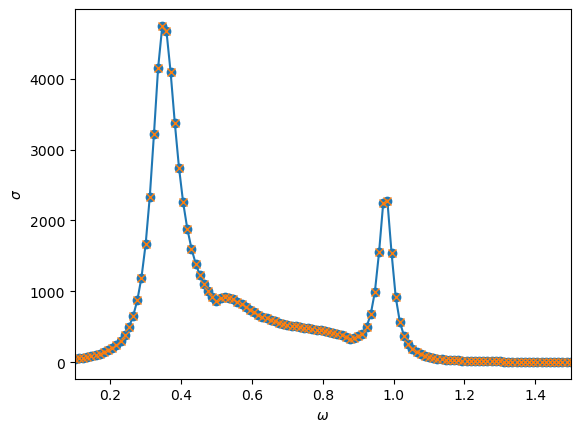

In [15]:
plt.plot(omegas,gains,'-o')
plt.plot(omegas,gains2,'x')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\sigma$')
plt.xlim([omegas[0],omegas[-1]])